In [1]:
from xradio.data.datasets import download

download(file="Antennae_North.cal.lsrk.vis.zarr", source="dropbox")

File exists.


In [2]:
import astroviper
from astroviper.client import local_client

viper_client = local_client(cores=4, memory_limit="4GB")
viper_client

# import dask
# dask.config.set(scheduler='synchronous')

log_parms {'log_to_term': False, 'log_to_file': False, 'log_file': 'viper_', 'log_level': 'INFO'}
[client.py:115 -         local_client() ] Created client <Client: 'tcp://127.0.0.1:63152' processes=4 threads=4, memory=14.90 GiB>


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 14.90 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:63152,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 14.90 GiB
Comm: tcp://127.0.0.1:63163,Total threads: 1
Dashboard: http://127.0.0.1:63167/status,Memory: 3.73 GiB
Nanny: tcp://127.0.0.1:63155,


In [3]:
ps_name = "Antennae_North.cal.lsrk.split.vis.zarr"

from xradio.vis.read_processing_set import read_processing_set

fields = ["NGC4038 - Antennae North"]
intents = ["OBSERVE_TARGET#ON_SOURCE"]
ps = read_processing_set(ps_name, intents=intents, fields=fields)
ps.summary()

,name,ddi,intent,field_id,field_name,start_frequency,end_frequency
0,Antennae_North.cal.lsrk.split_ddi_0_intent_OBS...,0,OBSERVE_TARGET#ON_SOURCE,1,NGC4038 - Antennae North,3.439281e+11,3.440067e+11
1,Antennae_North.cal.lsrk.split_ddi_0_intent_OBS...,0,OBSERVE_TARGET#ON_SOURCE,0,NGC4038 - Antennae North,3.439281e+11,3.440067e+11
2,Antennae_North.cal.lsrk.split_ddi_0_intent_OBS...,0,OBSERVE_TARGET#ON_SOURCE,2,NGC4038 - Antennae North,3.439281e+11,3.440067e+11


In [4]:
import numpy as np
import xarray as xr
import dask
from astroviper._concurrency._graph_tools import (
    _map,
    _reduce,
    _make_time_coord,
    _make_frequency_coord,
    _make_parallel_coord,
)
from astroviper._domain._image._moment_max import _moment_max
from astroviper._domain._imaging import _make_image


ps_name = "Antennae_North.cal.lsrk.vis.zarr"
intents = ["OBSERVE_TARGET#ON_SOURCE"]
ps = read_processing_set(ps_name, intents=intents)
ms_xds = ps.get(0)

grid_parms = {}
grid_parms["chan_mode"] = "cube"
grid_parms["image_size"] = [500, 500]
grid_parms["cell_size"] = np.array([-0.13, 0.13]) * np.pi / (180 * 3600)
grid_parms["fft_padding"] = 1.0
grid_parms["phase_direction"] = ps[
    "Antennae_North.cal.lsrk_ddi_0_intent_OBSERVE_TARGET#ON_SOURCE_field_id_12"
].attrs["field_info"]["phase_direction"]
grid_parms["polarization"] = ms_xds.polarization
grid_parms["frequency"] = None
grid_parms["time"] = [0]
input_parms = {}
input_parms["grid_parms"] = grid_parms
input_parms["to_disk"] = False

parallel_coords = {}
coord = _make_frequency_coord(
    freq_start=343018346078.4616,
    freq_delta=11231488.981445312,
    n_channels=166,
)
parallel_coords["frequency"] = _make_parallel_coord(coord=coord, n_chunks=20)

sel_parms = {}
sel_parms["fields"] = ["NGC4038 - Antennae North"]
sel_parms["intents"] = ["OBSERVE_TARGET#ON_SOURCE"]
graph = _map(
    input_data_name=ps_name,
    input_data_type="processing_set",
    ps_sel_parms=sel_parms,
    parallel_coords=parallel_coords,
    func_chunk=_make_image,
    input_parms=input_parms,
    client=None,
)
input_parms = {}
graph = _reduce(graph, _moment_max, input_parms)

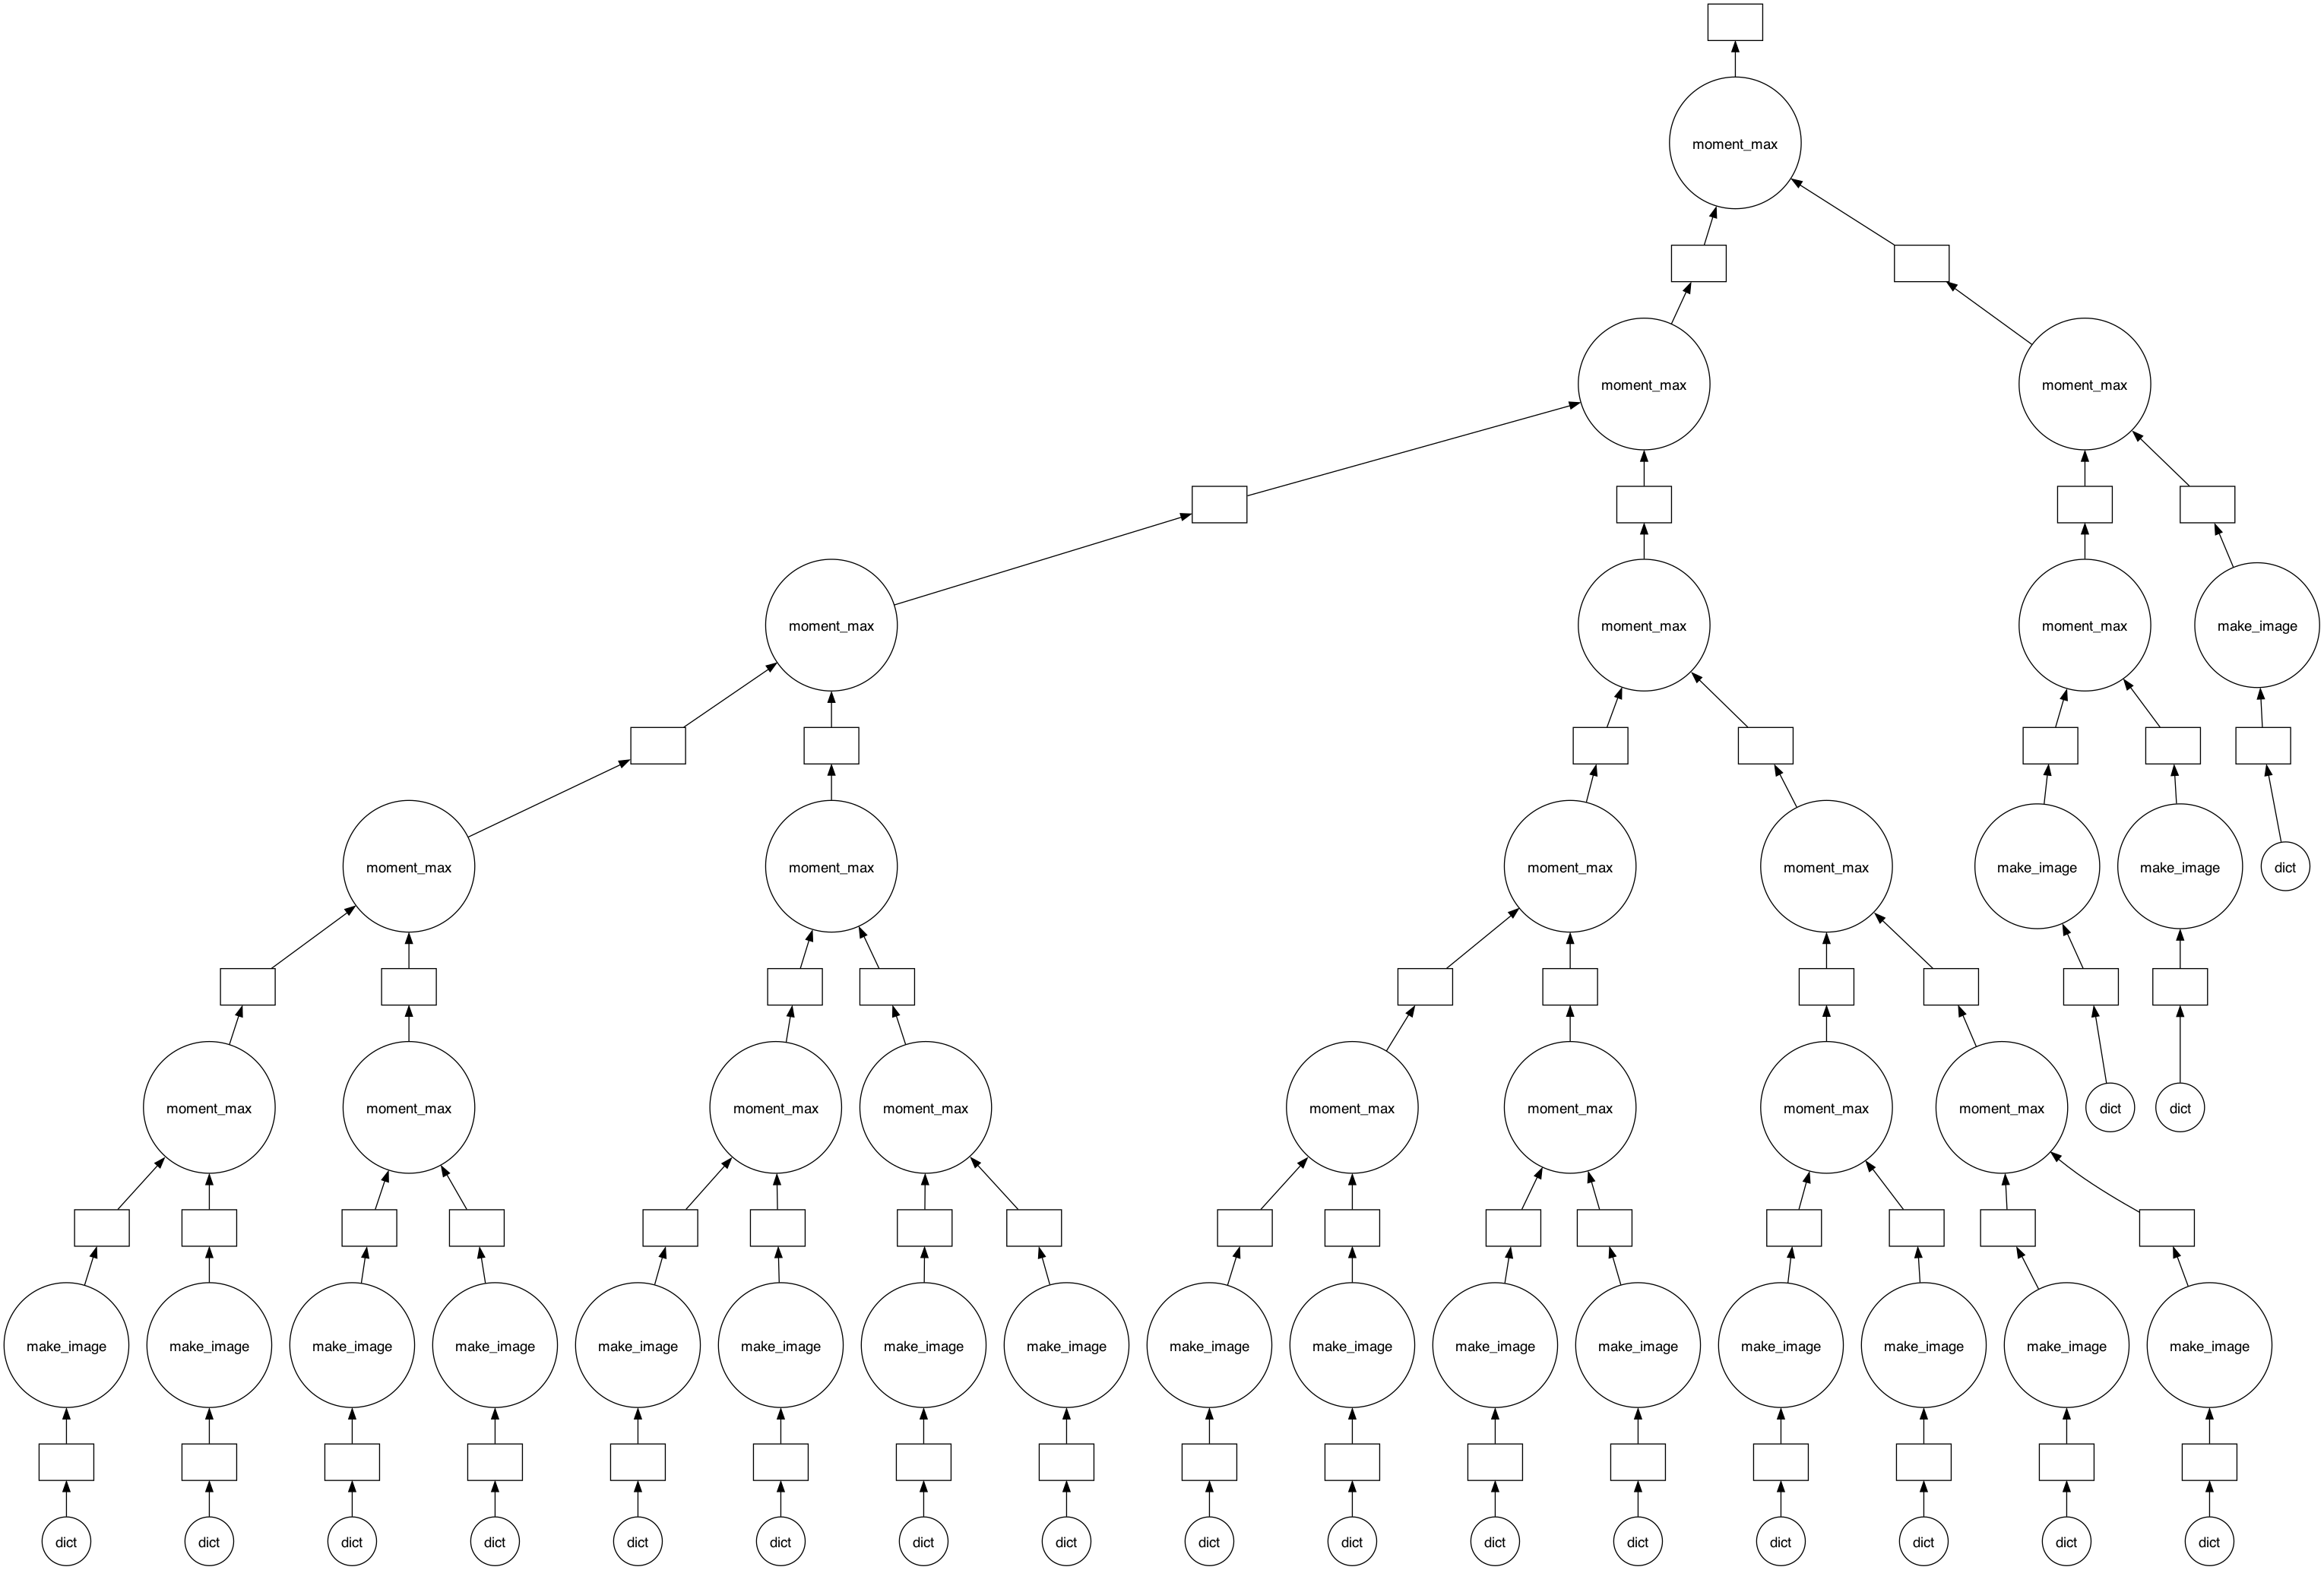

In [5]:
dask.visualize(graph)

In [6]:
img_xds = dask.compute(graph)[0][0][0]
img_xds

<xarray.Dataset>
Dimensions:                    (polarization: 2, time: 1, l: 500, m: 500,
                                frequency: 1, u: 500, v: 500, pol: 2)
Coordinates:
  * polarization               (polarization) <U2 'XX' 'YY'
  * time                       (time) float64 0.0
    right_ascension            (l, m) float64 3.15 3.15 3.15 ... 3.15 3.15 3.15
    declination                (l, m) float64 -0.3295 -0.3295 ... -0.3291
Dimensions without coordinates: l, m, frequency, u, v, pol
Data variables:
    APERTURE                   (frequency, polarization, u, v) complex128 0j ...
    APERTURE_NORMALIZATION     (frequency, polarization) float64 3.158 3.158
    UV_SAMPLING                (frequency, polarization, u, v) complex128 0j ...
    UV_SAMPLING_NORMALIZATION  (frequency, polarization) float64 5.914 5.914
    VISIBILITY                 (frequency, polarization, u, v) complex128 0j ...
    VISIBILITY_NORMALIZATION   (frequency, polarization) float64 3.156 3.156
    PRIMARY_BEAM               (frequency, pol, l, m) float64 nan nan ... nan
    POINT_SPREAD_FUNCTION      (frequency, pol, l, m) float64 nan nan ... nan
    SKY                        (frequency, pol, l, m) float64 nan nan ... nan

In [7]:
img_xds

<xarray.Dataset>
Dimensions:                    (polarization: 2, time: 1, l: 500, m: 500,
                                frequency: 1, u: 500, v: 500, pol: 2)
Coordinates:
  * polarization               (polarization) <U2 'XX' 'YY'
  * time                       (time) float64 0.0
    right_ascension            (l, m) float64 3.15 3.15 3.15 ... 3.15 3.15 3.15
    declination                (l, m) float64 -0.3295 -0.3295 ... -0.3291
Dimensions without coordinates: l, m, frequency, u, v, pol
Data variables:
    APERTURE                   (frequency, polarization, u, v) complex128 0j ...
    APERTURE_NORMALIZATION     (frequency, polarization) float64 3.158 3.158
    UV_SAMPLING                (frequency, polarization, u, v) complex128 0j ...
    UV_SAMPLING_NORMALIZATION  (frequency, polarization) float64 5.914 5.914
    VISIBILITY                 (frequency, polarization, u, v) complex128 0j ...
    VISIBILITY_NORMALIZATION   (frequency, polarization) float64 3.156 3.156
    PRIMARY_BEAM               (frequency, pol, l, m) float64 nan nan ... nan
    POINT_SPREAD_FUNCTION      (frequency, pol, l, m) float64 nan nan ... nan
    SKY                        (frequency, pol, l, m) float64 nan nan ... nan

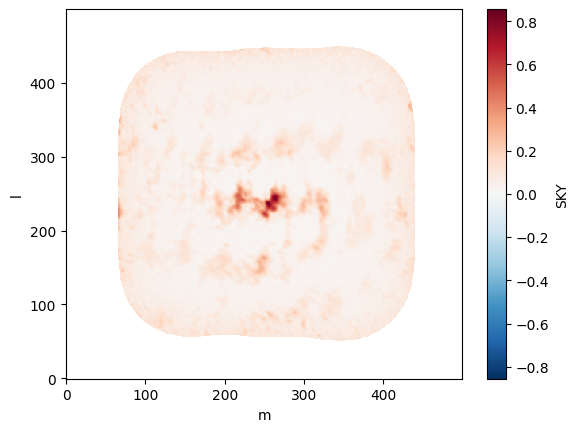

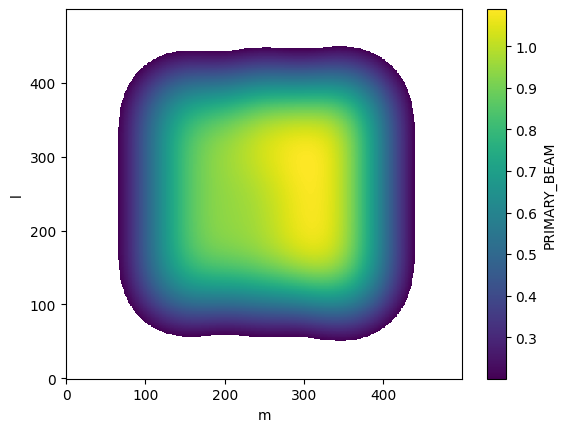

In [8]:
import matplotlib.pyplot as plt

plt.figure()
img_xds.SKY.isel(pol=0, frequency=0).plot()
plt.figure()
img_xds.PRIMARY_BEAM.isel(pol=0, frequency=0).plot()

In [10]:
img_xds.to_zarr("Antennae_North_MOM8.img.zarr", mode="w")